In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import itertools

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *
from scripts.plotting import *

In [2]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [3]:
ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]
t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='human')[0]
lib_meta = od+expand(config['lr']['meta'], species='human')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species='human')[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='human', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='human')[0]
major_isos = od+expand(config['lr']['analysis']['major_isos'], species='human', obs_col='sample')[0]
pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]
pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='human')[0]
gtf = od+expand(config['lr']['cerberus']['gtf'], species='human')[0]
phastcons = od+expand(config['ref']['phastcons100']['txt'])[0]


ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='human')[0]
ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='human')[0]

sr_ab = '../'+config['sr']['ab']


ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'protein_coding'
obs_col = 'sample'
go_gene_subset = 'protein_coding'

m_ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='mouse')[0]
m_filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='mouse')[0]
m_read_annot = od+expand(config['lr']['talon']['full_annot'], species='mouse')[0]
m_t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='mouse')[0]
m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]
m_swan_file = od+expand(config['lr']['swan']['sg'], species='mouse')[0]
m_cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='mouse', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='mouse')[0]
m_major_isos = od+expand(config['lr']['analysis']['major_isos'], species='mouse', obs_col='sample')[0]
m_pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='mouse', obs_col='sample')[0]
m_pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='mouse')[0]


m_ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='mouse')[0]
m_ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='mouse')[0]


orth_table = '../../proc_revisions/ref/biomart_human_to_mouse.tsv'
mouse_ver = 'vM25_cerberus'

In [4]:
source = 'obs_major'

186


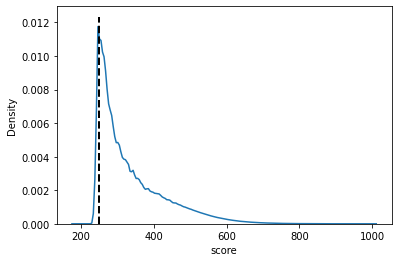

In [5]:
# read conserved elements in, threshold for a certain score
min_cons_score = 250
cons = pd.read_csv(phastcons, sep='\t', header=None,
                 names=['bin', 'Chromosome', 'Start', 'End', 'idk1', 'score'])
cons = cons[['Chromosome', 'Start', 'End', 'score']]
print(cons.score.min())
ax = sns.kdeplot(cons, x='score')
ylims = ax.get_ylim()
ax.vlines(min_cons_score, ylims[0], ylims[1],
                      colors='k', linestyles='dashed',
                      linewidth=2)
cons = cons.loc[cons.score >= min_cons_score]
cons = pr.PyRanges(cons)

In [6]:
# read gtf, limit to relevant columns
# only look at exons, calc exon len
gtf_df = pr.read_gtf(gtf, duplicate_attr=True).as_df()
gtf_df = gtf_df[['Chromosome', 'Start', 'End', 'gene_name',
                 'gene_id', 'transcript_id', 'Feature']]
gtf_df = gtf_df.loc[gtf_df.Feature=='exon']
gtf_df['exon_len'] = (gtf_df.Start-gtf_df.End).abs()

# get length of each transcript
gb_cols = ['transcript_id']
keep_cols = gb_cols + ['exon_len']
temp3 = gtf_df[keep_cols].groupby(gb_cols).sum().reset_index().rename({'exon_len':'t_len'}, axis=1)

In [7]:
gtf_df = pr.PyRanges(gtf_df)
gtf_df = gtf_df.join(cons, report_overlap=True)

In [8]:
# ensure that phastcons things are non-overlapping
cons = cons.df
cons['region_id'] = cons.Chromosome.astype(str)+'_'+cons.Start.astype(str)+'_'+cons.End.astype(str)
cons = pr.PyRanges(cons)
temp = cons.join(cons)
temp.head()
temp = temp.df
assert len(temp.loc[temp.region_id!=temp.region_id_b]) == 0

In [9]:
import sys
sys.getsizeof(cons)

64

In [10]:
import sys
sys.getsizeof(gtf_df)

64

In [11]:
# gtf_df_back = gtf_df.df.copy(deep=True)

In [12]:
# gtf_df = gtf_df_back

In [13]:
# gtf_df = gtf_df_back
gtf_df = gtf_df.df

# # get bp overlap / exon
gb_cols = ['transcript_id']
keep_cols = gb_cols+['Overlap']
temp2 = gtf_df[keep_cols].groupby(gb_cols).sum().reset_index().rename({'overlap':'cons_len'}, axis=1)

temp = temp3.merge(temp2, how='left', on=['transcript_id'])

In [14]:
# add in gene info
temp = temp.merge(gtf_df[['gene_id', 'gene_name', 'transcript_id']].drop_duplicates(),
                  how='left',
                  on='transcript_id')

del gtf_df

In [15]:
# compute % conservation
temp['perc_cons'] = (temp['Overlap']/temp['t_len'])*100

In [16]:
temp.head()

,transcript_id,t_len,Overlap,gene_id,gene_name,perc_cons
0,"ENSG00000000003[1,1,1]",3868,1033.0,ENSG00000000003.14,TSPAN6,26.706308
1,"ENSG00000000003[1,1,5]",2306,951.0,ENSG00000000003.14,TSPAN6,41.240243
2,"ENSG00000000003[1,1,6]",3225,958.0,ENSG00000000003.14,TSPAN6,29.705426
3,"ENSG00000000003[1,1,7]",2096,951.0,ENSG00000000003.14,TSPAN6,45.372137
4,"ENSG00000000003[1,1,8]",1282,827.0,ENSG00000000003.14,TSPAN6,64.508580


In [17]:
temp.sort_values(by='perc_cons', ascending=False)

,transcript_id,t_len,Overlap,gene_id,gene_name,perc_cons
185276,"ENSG00000182700[3,1,2]",356,356.0,ENSG00000182700.4,IGIP,100.0
244113,"ENSG00000280800[2,2,2]",1643,1643.0,ENSG00000280800.1,ENSG00000280800,100.0
185026,"ENSG00000182568[14,6,15]",366,366.0,ENSG00000182568.16,SATB1,100.0
220911,"ENSG00000231940[2,1,1]",135,135.0,ENSG00000231940.1,RPS7P3,100.0
244032,"ENSG00000280614[1,1,1]",1023,1023.0,ENSG00000280614.1,ENSG00000280614,100.0
...,...,...,...,...,...,...
245870,"TALONG000277403[1,1,1]",699,NaN,NaN,NaN,NaN
245871,"TALONG000277403[1,2,2]",2144,NaN,NaN,NaN,NaN
245874,"TALONG000281814[1,1,1]",1418,NaN,NaN,NaN,NaN
245878,"TALONG000285649[1,1,1]",1015,NaN,NaN,NaN,NaN


In [18]:
# get median % exonic conservation per gene across transcripts
temp = temp[['gene_name',
             'gene_id',
             'perc_cons']].groupby(['gene_name',
                                    'gene_id']).median().reset_index().rename({'perc_cons':'med_perc_cons'}, axis=1)

In [19]:
temp.sort_values(by='med_perc_cons', ascending=False)


,gene_name,gene_id,med_perc_cons
17380,MIR1306,ENSG00000284464.1,100.000000
22700,RNA5SP108,ENSG00000271924.1,100.000000
17745,MIR744,ENSG00000266297.1,100.000000
10279,ENSG00000278752,ENSG00000278752.1,100.000000
10825,ENSG00000280614,ENSG00000280614.1,100.000000
...,...,...,...
15723,LINC00205,ENSG00000223768.2,0.085741
13532,HEXA-AS1,ENSG00000260339.1,0.072046
6165,ENSG00000218672,ENSG00000218672.1,0.060569
10074,ENSG00000276791,ENSG00000276791.1,0.059701


In [32]:
hm_gids = get_human_mouse_gid_table(orth_table)

# ca = cerberus.read(cerberus_h5)
# m_ca = cerberus.read(m_cerberus_h5)

# restrict sample triplets to mm ones
ca = cerberus.read(cerberus_h5)
samples = get_mouse_match_samples()
inds = ca.triplets.loc[(ca.triplets.source == 'sample_det')&\
                       ~(ca.triplets['sample'].isin(samples))].index
ca.triplets.drop(inds, axis=0, inplace=True)
ca.triplets.loc[ca.triplets.source == 'sample_det', 'source'] = 'sample_mm_det'
ca = get_centroids(ca, 
                   source='sample_mm_det',
                   gene_subset=gene_subset,
                   ver=ver)

# add suffix to mouse sources
m_ca = cerberus.read(m_cerberus_h5)
m_ca.triplets.loc[m_ca.triplets.source == 'sample_det', 'source'] ='sample_det_mouse'
m_ca = get_centroids(m_ca,
                     source='sample_det_mouse',
                     gene_subset=gene_subset,
                     ver=mouse_ver)

# merge in mouse gids that we need
ca.triplets = ca.triplets.merge(hm_gids, how='inner', left_on='gid', right_on='Gene stable ID')

# merge in mouse data
m_ca.triplets = m_ca.triplets.merge(hm_gids, how='inner', left_on='gid', right_on='Mouse gene stable ID')

df = compute_dists([ca, m_ca],
                   ['sample_mm_det_centroid', 
                   'sample_det_mouse_centroid'],
                   gene_subsets=[gene_subset, gene_subset],
                   ver=[ver,  mouse_ver],
                   gene_merge=['Gene stable ID'])

In [34]:
[c for c in df.columns if 'sector' in c]

['sector_sample_mm_det_centroid', 'sector_sample_det_mouse_centroid']

In [35]:
# merge the conservation scores in with the distance df
temp['gid'] = cerberus.get_stable_gid(temp, 'gene_id')
df2 = df[['gid_sample_mm_det_centroid', 'dist', 'z_score']+\
         [c for c in df.columns if 'sector' in c]].copy(deep=True)
df2.rename({'gid_sample_mm_det_centroid':'gid',
            'sector_sample_mm_det_centroid': 'sector_human',
            'sector_sample_det_mouse_centroid': 'sector_mouse'}, axis=1, inplace=True)
df2.head()


,gid,dist,z_score,sector_human,sector_mouse
0,ENSG00000112699,0.026948,-1.166066,mixed,mixed
1,ENSG00000112936,0.044918,-0.914363,mixed,simple
2,ENSG00000147650,0.123386,0.184709,mixed,mixed
3,ENSG00000157593,0.155535,0.635010,splicing,splicing
4,ENSG00000157600,0.082907,-0.382270,mixed,mixed


In [36]:
temp.head()

,gene_name,gene_id,med_perc_cons,gid
0,5_8S_rRNA,ENSG00000277739.1,69.565217,ENSG00000277739
1,7SK,ENSG00000202198.1,79.118329,ENSG00000202198
2,7SK,ENSG00000271394.1,10.662824,ENSG00000271394
3,7SK,ENSG00000276626.1,0.872093,ENSG00000276626
4,A1BG,ENSG00000121410.11,4.353443,ENSG00000121410


In [37]:
df2.head()

,gid,dist,z_score,sector_human,sector_mouse
0,ENSG00000112699,0.026948,-1.166066,mixed,mixed
1,ENSG00000112936,0.044918,-0.914363,mixed,simple
2,ENSG00000147650,0.123386,0.184709,mixed,mixed
3,ENSG00000157593,0.155535,0.635010,splicing,splicing
4,ENSG00000157600,0.082907,-0.382270,mixed,mixed


In [38]:
df2 = df2.merge(temp, how='left', on='gid')

In [39]:
df2.head()

,gid,dist,z_score,sector_human,sector_mouse,gene_name,gene_id,med_perc_cons
0,ENSG00000112699,0.026948,-1.166066,mixed,mixed,GMDS,ENSG00000112699.10,42.312218
1,ENSG00000112936,0.044918,-0.914363,mixed,simple,C7,ENSG00000112936.18,43.197279
2,ENSG00000147650,0.123386,0.184709,mixed,mixed,LRP12,ENSG00000147650.11,85.569772
3,ENSG00000157593,0.155535,0.635010,splicing,splicing,SLC35B2,ENSG00000157593.18,56.379260
4,ENSG00000157600,0.082907,-0.382270,mixed,mixed,TMEM164,ENSG00000157600.11,37.698012


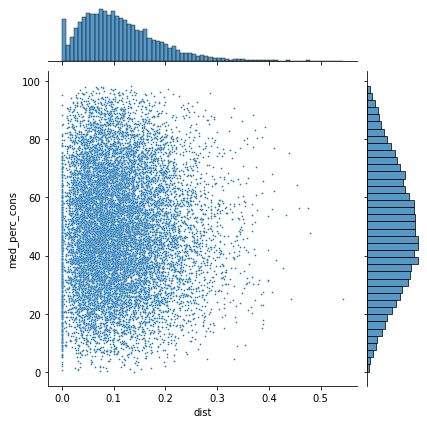

In [40]:
sns.jointplot(df2, x='dist', y='med_perc_cons', s=3)

In [41]:
rho, p = st.spearmanr(df2['dist'].tolist(), df2['med_perc_cons'].tolist())
r, p2 = st.pearsonr(df2['dist'].tolist(), df2['med_perc_cons'].tolist())
print('Rho={:.2f}\nR={:.2f}'.format(rho,r))

Rho=0.01
R=0.00


In [42]:
df2.head()

,gid,dist,z_score,sector_human,sector_mouse,gene_name,gene_id,med_perc_cons
0,ENSG00000112699,0.026948,-1.166066,mixed,mixed,GMDS,ENSG00000112699.10,42.312218
1,ENSG00000112936,0.044918,-0.914363,mixed,simple,C7,ENSG00000112936.18,43.197279
2,ENSG00000147650,0.123386,0.184709,mixed,mixed,LRP12,ENSG00000147650.11,85.569772
3,ENSG00000157593,0.155535,0.635010,splicing,splicing,SLC35B2,ENSG00000157593.18,56.379260
4,ENSG00000157600,0.082907,-0.382270,mixed,mixed,TMEM164,ENSG00000157600.11,37.698012


In [29]:
df2.to_csv('median_perc_cons_human_mouse_dist.tsv', sep='\t', index=False)

T-test for cons vs non cons mixed sector genes based on median % sequence conserved: 4.962689902856966, p=7.091361649696876e-07
T-test for cons vs non cons splicing sector genes based on median % sequence conserved: 2.936328186435895, p=0.0033789105065158503
T-test for cons vs non cons simple sector genes based on median % sequence conserved: -3.702345755697338, p=0.00022271290324443082
T-test for cons vs non cons tes sector genes based on median % sequence conserved: 5.520870472114569, p=3.8179397129510555e-08
T-test for cons vs non cons tss sector genes based on median % sequence conserved: 2.6072793469752122, p=0.009358122649235101


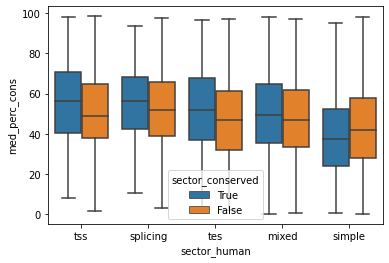

In [55]:
# for each sector, compare the median % conservation of the gene for sector
# conserved and sector non-conserved
c_dict, order = get_sector_colors()
df2['sector_conserved'] = df2.sector_human==df2.sector_mouse
ax = sns.boxplot(df2, x='sector_human', hue='sector_conserved', y='med_perc_cons',
                 hue_order=[True, False], order=order)
for s in df2.sector_human.unique().tolist():
    temp = df2.loc[df2.sector_human == s].copy(deep=True)
    a = temp.loc[temp.sector_conserved==True, 'med_perc_cons'].tolist()
    b = temp.loc[temp.sector_conserved==False, 'med_perc_cons'].tolist()
    
    result, p = scipy.stats.ttest_ind(a, b)
    print(f'T-test for cons vs non cons {s} sector genes based on median % sequence conserved: {result}, p={p}')
    

<AxesSubplot:xlabel='med_perc_cons', ylabel='Density'>

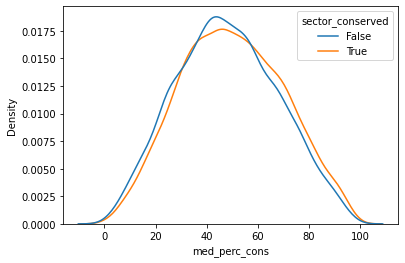

In [51]:
sns.kdeplot(df2, x='med_perc_cons', hue='sector_conserved', common_norm=False)

## How correlated is the total number of unique exons for genes that are conserved vs. not conserved?

In [11]:
# major isoform triplets mouse match 
h_source = 'obs_mm_major'
m_source = 'obs_major'
gene_subset = ['protein_coding']
h_ver='v40_cerberus'
m_ver='vM25_cerberus'

# read in triplets and limit to source
ca = cerberus.read(cerberus_h5)
h_df = ca.triplets.loc[ca.triplets.source == h_source]

ca = cerberus.read(m_cerberus_h5)
m_df = ca.triplets.loc[ca.triplets.source == m_source]

def subset_on_dict(df, subset):
    for col, val in subset.items():
            if type(val) != list:
                val = [val]
            df = df.loc[df[col].isin(val)]
    return df

# # limit to samples if given
# if h_subset:
#     h_df = subset_on_dict(h_df, h_subset)
# if m_subset:
#     m_df = subset_on_dict(m_df, m_subset)

# get sectors for each gene
h_df = assign_gisx_sector(h_df)
m_df = assign_gisx_sector(m_df)

# merge in gene info and subset
if gene_subset:
    gene_df, _, _ = get_gtf_info(how='gene', ver=h_ver)
    gene_df['gid'] = cerberus.get_stable_gid(gene_df, 'gid')
    h_df = h_df.merge(gene_df[['gid', 'biotype_category']],
                      how='left', on='gid')
    gene_df, _, _ = get_gtf_info(how='gene', ver=m_ver)
    gene_df['gid'] = cerberus.get_stable_gid(gene_df, 'gid')
    m_df = m_df.merge(gene_df[['gid', 'biotype_category']],
                      how='left', on='gid')
    h_df = h_df.loc[h_df.biotype_category.isin(gene_subset)]
    m_df = m_df.loc[m_df.biotype_category.isin(gene_subset)]

# get matching gids from human and mouse
# d = os.path.dirname(__file__)
# fname = '../ref/biomart_human_to_mouse.tsv'
df = get_human_mouse_gid_table(orth_table)

df = df.merge(h_df, how='right', left_on='Gene stable ID',
              right_on='gid')

df = df.merge(m_df, how='right', left_on='Mouse gene stable ID',
              right_on='gid', suffixes=('_human', '_mouse'))

# get only genes that are both expressed
df = df.loc[~(df.sector_human.isnull())&~(df.sector_mouse.isnull())]


# get all ortholog calls
all_gids = df['Gene stable ID'].tolist()
print(len(all_gids))

13494


In [10]:
[c for c in df.columns if 'sector' in c]

['sector_sample_mm_det_centroid', 'sector_sample_det_mouse_centroid']

In [12]:
df['same_sector'] = df.sector_human==df.sector_mouse

In [19]:
df.gid_mouse.head()

0    ENSMUSG00000000001
1    ENSMUSG00000000028
2    ENSMUSG00000000037
4    ENSMUSG00000000056
5    ENSMUSG00000000058
Name: gid_mouse, dtype: object

In [20]:
ca = cerberus.read(cerberus_h5)
ic_h = ca.ic.loc[ca.ic.gene_id.isin(df.gid_human.tolist())]
# ic_h.head()

,Chromosome,Strand,Coordinates,Name,source,novelty,gene_id,ic
0,chr1,+,-,ENSG00000004487_18,"v40,v29,lapa",Known,ENSG00000004487,18
1,chr1,+,-,ENSG00000033122_5,"v40,v29,lapa",Known,ENSG00000033122,5
2,chr1,+,-,ENSG00000049246_6,"v40,v29,lapa",Known,ENSG00000049246,6
3,chr1,+,-,ENSG00000077157_8,"v40,v29,lapa",Known,ENSG00000077157,8
4,chr1,+,-,ENSG00000099260_3,"v40,v29,lapa",Known,ENSG00000099260,3


In [22]:
h_df, h_df2 = get_exon_from_ic(ic_h, ref_sources=['v40', 'v29'])

NameError: name 'get_exon_from_ic' is not defined

In [21]:
ca = cerberus.read(m_cerberus_h5)
ic_m = ca.ic.loc[ca.ic.gene_id.isin(df.gid_mouse.tolist())]
ic_m.head()

,Chromosome,Strand,Coordinates,Name,source,novelty,gene_id,ic
0,chr1,+,-,ENSMUSG00000001138_3,"vM25,vM21,lapa",Known,ENSMUSG00000001138,3
1,chr1,+,-,ENSMUSG00000007805_1,"vM25,vM21,lapa",Known,ENSMUSG00000007805,1
2,chr1,+,-,ENSMUSG00000015314_4,"vM25,vM21,lapa",Known,ENSMUSG00000015314,4
3,chr1,+,-,ENSMUSG00000016494_3,"vM25,vM21,lapa",Known,ENSMUSG00000016494,3
6,chr1,+,-,ENSMUSG00000025777_2,"vM25,vM21,lapa",Known,ENSMUSG00000025777,2
